# Th01: Introduction

Final presentation of the encoder + prescribed reg. head evaluation results (trimmed). 

# Th01: Environment and data handling

## Environment setup

Install dependencies:

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 13.7 MB/s 


Import modules:

In [ ]:
# math
import numpy as np
from numpy import array
from numpy.linalg import norm
import math

# os
import os
from os import F_OK
from os import listdir
from os.path import isfile, join
import sys

# ML
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as skm
from keras.callbacks import ModelCheckpoint, EarlyStopping

# dataprep 
import pandas_datareader.data as web
import pandas as pd
from datetime import datetime #timeseries - if needed

# visualisation
import matplotlib.pyplot as plt

# filesystem
from google.colab import drive
import pickle

# model weight loading for 'sequential' evaluation
load_weights = [True,True, True, True] # 0 - Robust encoder, 1 - PUT encoder, 2 - Put encoder unknown terrain, 3- Robust encoder unkown terrain

# currently evaluated version/variant of the network
current_variant = ''

print("On: " + str(datetime.now()) + " -> Import successful")

On: 2021-12-12 19:57:05.188000 -> Import successful


Google Drive + directory markers:

In [ ]:
# define globally accessible variables == dir/file paths to the datasets; default -> for local training

# connect to the drive
drive.mount('/content/drive')

# dir/file paths to the datasets:

# 1. raw
datasets_file_path_raw = 'filepath_to_raw_data_dataset' # + filename
fpath_dataset_raw_filenames = [f for f in listdir(datasets_file_path_raw) if isfile(join(datasets_file_path_raw, f))]

# 2. pickle 
datasets_file_path_pickle = '/content/drive/MyDrive/filepath_to_pickle_dataset' # + friction / + friction_classes
fpath_pickle_friction = datasets_file_path_pickle + 'friction.pickle'
fpath_pickle_friction_classes = datasets_file_path_pickle + 'friction_classes.pickle'


# working directories

notepad_dir = '/content/drive/MyDrive/Colab Notebooks/notepad_directory'

model_data_dir = notepad_dir + 'Th01_models_and_output_data'








Mounted at /content/drive


## Data

Load data:

In [ ]:
# load data from the defined filepath directories 

dataset_friction_file = open(fpath_pickle_friction, 'rb')
dataset_loaded = pickle.load(dataset_friction_file, encoding='latin1')
dataset_friction_file.close()

Preprocess x and y datasets

In [ ]:
# verify loaded data structures
dataset_loaded.keys()

dict_keys(['val_ds', 'train_ds', 'test_ds', 'signal_stats', 'classes_weights'])

In [ ]:
# prepare training data, list

def prepare_x_y_data(dset: dict, collection: str, verbose: bool, drop_classes = []):
  # dset: pickle dataset prepared by Mikołaj 
  # collection: marker that defines which subset of data to prepare - validation, training or test chunk
  # verbose: whether to display the 'load monit' or not
  # drop_classes: for the second part of the experiment -> load data without given classes of signals
  
  x = []
  y = []
  y_labels = []

  for i in range(len(dset[collection])):
    if dset[collection][i]['label'] in drop_classes:
        pass
    else:   
      x.append(dset[collection][i]['signal'])
      y.append(dset[collection][i]['friction'])
      y_labels.append(dset[collection][i]['label'])
      

  if verbose == True:
    print('In ' + collection + ' -> x array length = ' + str(len(x)) + ' shape elements in x = ' + str(x[0].shape) )
    print('In ' + collection + ' -> y array length = ' + str(len(y)) + ' y[0] = ' + str(y[0]) )
    print('In ' + collection + ' -> y array length = ' + str(len(y_labels)) + ' y_labels[0] = ' + str(y_labels[0]) )

  return x,y,y_labels


# prepare datasets; call the function defined above

x_train, y_train, y_train_labels = prepare_x_y_data(dataset_loaded, 'train_ds', True)
x_val, y_val, y_val_labels = prepare_x_y_data(dataset_loaded, 'val_ds', True)
x_test, y_test, y_test_labels = prepare_x_y_data(dataset_loaded, 'test_ds', True)



# prepare label designations; for evaluation purposes

ENUM_LABELS = ['Artificial Grass',
               'Gum',
               'Carpet',
               'PVC',
               'Ceramic Tiles',
               'Foam',
               'Sand',
               'Rocks']



In train_ds -> x array length = 3443 shape elements in x = (160, 6)
In train_ds -> y array length = 3443 y[0] = 0.5753798660343042
In train_ds -> y array length = 3443 y_labels[0] = 4
In val_ds -> x array length = 1148 shape elements in x = (160, 6)
In val_ds -> y array length = 1148 y[0] = 1.5229850247598293
In val_ds -> y array length = 1148 y_labels[0] = 0
In test_ds -> x array length = 1148 shape elements in x = (160, 6)
In test_ds -> y array length = 1148 y[0] = 0.5753798660343042
In test_ds -> y array length = 1148 y_labels[0] = 4


# Th01: Version 1 -> Robust variant of the model from the article

## Model construction and training 

Construct the model

In [ ]:
# Name: Robust encoder


## NOTE ## 
# How to define convolution nn input 
# input_shape = (160, 6) -> 160 timesteps, 6 feats


regressor = tf.keras.Sequential()
regressor.add(tf.keras.layers.InputLayer(input_shape = x_train[0].shape))

regressor.add(tf.keras.layers.Convolution1D(filters = 32,kernel_size=81, activation='relu'))
regressor.add(tf.keras.layers.Convolution1D(filters = 64,kernel_size=41, activation='relu'))

regressor.add(tf.keras.layers.GRU(units = 128, activation = 'relu', return_sequences= True,))
regressor.add(tf.keras.layers.GRU(units = 128, activation='relu'))


regressor.add(tf.keras.layers.Dense(units = 128)) 
regressor.add(tf.keras.layers.BatchNormalization()) 
regressor.add(tf.keras.layers.ReLU()) 
regressor.add(tf.keras.layers.Dropout(rate=0.2))
regressor.add(tf.keras.layers.Dense(units = 1))

regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 80, 32)            15584     
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 64)            84032     
                                                                 
 gru (GRU)                   (None, 40, 128)           74496     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                        

Compile the model 

In [ ]:
from tensorflow_addons.optimizers import AdamW
lr = 0.001
wd = 2e-4


regressor.compile(optimizer=AdamW(weight_decay=wd,learning_rate=lr),loss='MAE')

Train the model

In [ ]:
current_variant = 'Version_1_variant_1_best'
 

if load_weights[0] == True:
  regressor.load_weights(model_data_dir + '/' +current_variant)
  
else:
  checkpoint = ModelCheckpoint(filepath=model_data_dir + '/' +current_variant,
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
  
  
  callbacks  = [checkpoint]

  regressor.fit(x = np.asarray(x_train), y = np.asarray(y_train), validation_data=(np.asarray(x_val),np.asarray(y_val)), epochs= 5000,callbacks= callbacks, batch_size=128)


Validate training accuracy

In [ ]:
# validate the results
regressor.load_weights(model_data_dir + '/' +current_variant)
metrics = regressor.evaluate(x = np.asarray(x_val), y = np.asarray(y_val))
print('MAE on validation data: ' + str(metrics))

36/36 [==============================] - 2s 25ms/step - loss: 0.0606
MAE on validation data: 0.06061539426445961


## Model functioning evaluation 

Obtain coefficient estimates:

In [ ]:
y_hat_1 = regressor.predict(x = np.asarray(x_test), batch_size = 1)

Display model evaluation metrics:

Version_1_variant_1_best
--- average values ---
1.4653597
1.4061162
1.8879541
0.8463197
0.61208314
1.5440848
0.5744978
0.69689345
--- percentage differences ---
3.7837100180115657
3.1278647049676866
5.0202010534530555
4.175237444745816
6.378963388836656
2.7499972406942352
8.212465082469711
0.913932898880776
--- standard_deviations ---
0.23289734
0.12164773
0.19477455
0.2734321
0.12742679
0.15270527
0.07783585
0.07330942
--- accuracy metrics for the entire vector of predictions ---
1. Explained Variance: 0.9051874701038429
2. Max Error: 1.0264260157121092
3. Mean Absolute Error: 0.05973170937047592
4. Root Mean Squared Error: 0.02485074116548561
5. R2 score: 0.905167829450478
--- plots ---


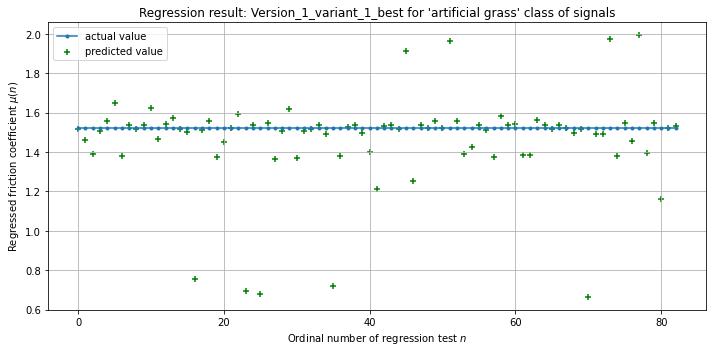

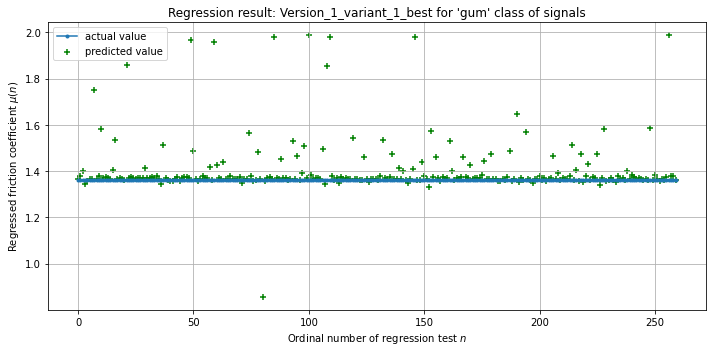

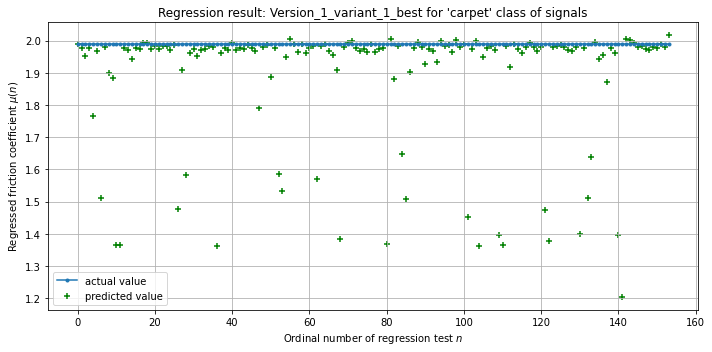

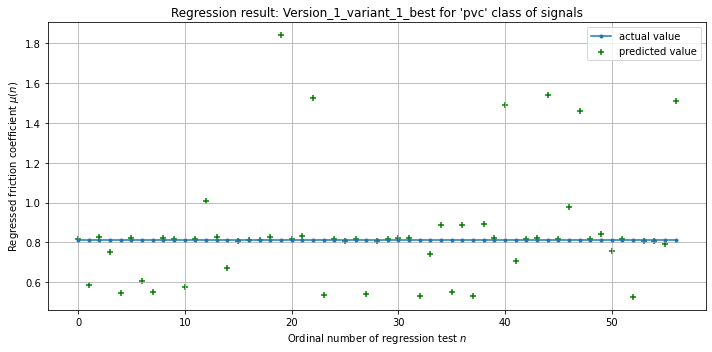

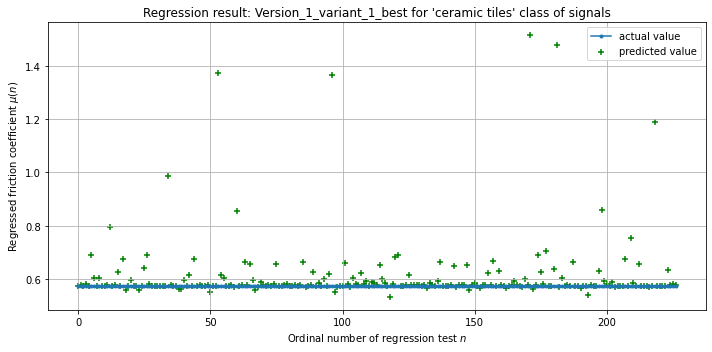

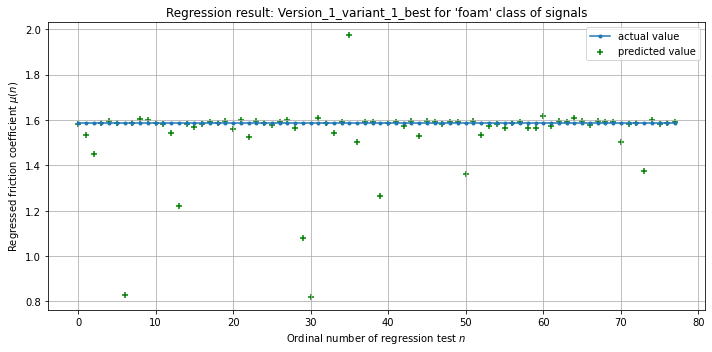

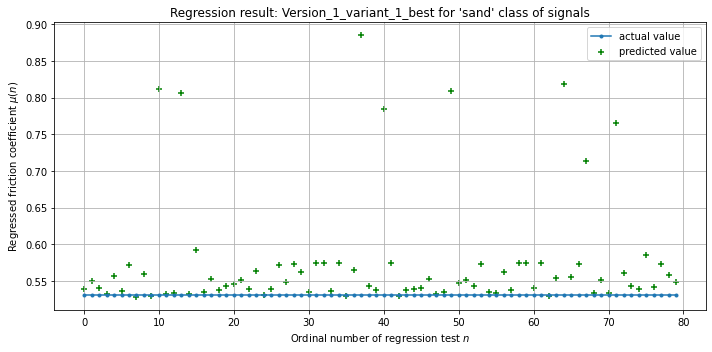

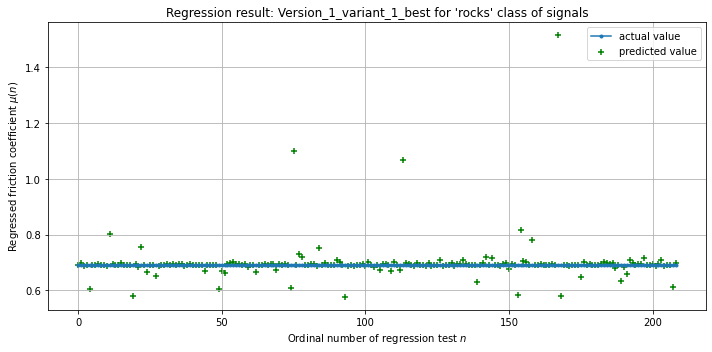

In [ ]:
# display current variant
print(current_variant)

# tests_frame is a 2D array, where i in <0,7>, j in <0, i_th_category_len> 
tests_frame = [[],[],[],[],[],[],[],[]]
actual_coefficients = [0,0,0,0,0,0,0,0]

# split tested data into arrays 
for i in range(len(y_test)):
  predicted = y_hat_1[i][0] # obtain predicted value
  actual = y_test[i] # obtain actual value
  
  tested_material = int(y_test_labels[i]) 
  tests_frame[tested_material].append(predicted)
  actual_coefficients[tested_material] = actual


# calculate average values of obtained predictions
print('--- average values ---')
average_values = [0,0,0,0,0,0,0,0]

for i in range(len(average_values)):
  average_values[i] = np.average(np.asarray(tests_frame[i]))
  print(average_values[i])


# calculate percentage differences
print("--- percentage differences ---")

percentage_differences = [0,0,0,0,0,0,0,0]

for i in range(len(percentage_differences)):
  percentage_differences[i] = 100*abs(1-average_values[i]/actual_coefficients[i])
  print(percentage_differences[i])


# calculate percentage differences
print("--- standard_deviations ---")

standard_deviations = [0,0,0,0,0,0,0,0]

for i in range(len(standard_deviations)):
  standard_deviations[i] = np.std(np.asarray(tests_frame[i]))

  print(standard_deviations[i])

print('--- accuracy metrics for the entire vector of predictions ---')
print('1. Explained Variance: ' + str(skm.explained_variance_score(y_test,y_hat_1)))
print('2. Max Error: ' + str(skm.max_error(y_test,y_hat_1)))
print('3. Mean Absolute Error: ' + str(skm.mean_absolute_error(y_test,y_hat_1)))
print('4. Root Mean Squared Error: '+str(skm.mean_squared_error(y_test,y_hat_1)))
print('5. R2 score: '+ str(skm.r2_score(y_test,y_hat_1)))

print('--- plots ---')

for i in range(len(tests_frame)):
  plt.figure(i)
  figure = plt.gcf()
  figure.set_size_inches(10, 5)
  plt.scatter([i for i in range(len(tests_frame[i]))],tests_frame[i], label = 'predicted value', c = 'green', marker ='+')
  plt.plot(len(tests_frame[i])*[actual_coefficients[i]], label = 'actual value', marker = '.')
  plt.legend(loc = 'best')
  plt.title("Regression result: " + current_variant + " for '" + ENUM_LABELS[i].lower() + "' class of signals")
  plt.grid()
  plt.xlabel("Ordinal number of regression test $n$")
  plt.ylabel("Regressed friction coefficient $\mu(n)$")

  plt.tight_layout()
  plt.savefig(model_data_dir + '/' +current_variant + '/{}_result_{}.png'.format(current_variant,i), dpi = 200)

plt.show()


# Th01: Version 2 -> Actual model used in the regression in the article


## Model construction and training 

Construct the model; definition of the custom layers. Copied from the putpy_nn library.

In [ ]:
# custom layers from putnn 
class MaskedDropout(tf.keras.Model):

    def __init__(self, rate, noise_shape=None, seed=None, name=None, **kwargs):
        super(MaskedDropout, self).__init__(name=name)
        self.dr = tf.keras.layers.Dropout(rate=rate, noise_shape=noise_shape, seed=seed, name=name, **kwargs)
        self.supports_masking = True

    def call(self, inputs, training=None, mask=None):
        if mask is None:
            mask = tf.ones(tf.shape(inputs)[:-1], tf.bool)

        idx = tf.where(mask)

        selected = tf.gather_nd(inputs, idx)
        output = self.dr(selected, training=training)

        x = tf.scatter_nd(tf.cast(idx, tf.int32), output, tf.shape(inputs))
        return x

class MaskedActivation(tf.keras.layers.Activation):

    def __init__(self, activation, axis=-1, **kwargs):
        super(MaskedActivation, self).__init__(activation, **kwargs)
        self.supports_masking = True
        self.axis = axis

    def call(self, inputs, mask=None):
        x = super(MaskedActivation, self).call(inputs)
        if mask is not None:
            return x * tf.cast(tf.expand_dims(mask, self.axis), inputs.dtype)
        return x


class MaskedBatchNormalization(tf.keras.Model):

    def __init__(self,
                 axis=-1,
                 momentum=0.99,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 moving_mean_initializer='zeros',
                 moving_variance_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 renorm=False,
                 renorm_clipping=None,
                 renorm_momentum=0.99,
                 fused=None,
                 trainable=True,
                 virtual_batch_size=None,
                 adjustment=None,
                 name=None,
                 **kwargs):
        super(MaskedBatchNormalization, self).__init__(name=name)
        self.bn = tf.keras.layers.BatchNormalization(
            axis=axis,
            momentum=momentum,
            epsilon=epsilon,
            center=center,
            scale=scale,
            beta_initializer=beta_initializer,
            gamma_initializer=gamma_initializer,
            moving_mean_initializer=moving_mean_initializer,
            moving_variance_initializer=moving_variance_initializer,
            beta_regularizer=beta_regularizer,
            gamma_regularizer=gamma_regularizer,
            beta_constraint=beta_constraint,
            gamma_constraint=gamma_constraint,
            renorm=renorm,
            renorm_clipping=renorm_clipping,
            renorm_momentum=renorm_momentum,
            fused=fused,
            trainable=trainable,
            virtual_batch_size=virtual_batch_size,
            adjustment=adjustment,
            name=name,
            **kwargs)
        self.supports_masking = True

    def call(self, inputs, training=None, mask=None):
        if mask is None:
            mask = tf.ones(tf.shape(inputs)[:-1], tf.bool)

        idx = tf.where(mask)

        selected = tf.gather_nd(inputs, idx)
        output = self.bn(selected, training=training)

        return tf.scatter_nd(tf.cast(idx, tf.int32), output, tf.shape(inputs))


class MaskedConv1D(tf.keras.layers.Conv1D):

    def __init__(self,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='valid',
                 data_format=None,
                 dilation_rate=1,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(MaskedConv1D, self).__init__(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            dilation_rate=dilation_rate,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs)

        self.features_axis = 2 if self.data_format == 'channels_last' else 1
        self.proc = tf.keras.layers.MaxPooling1D(pool_size=1, strides=self.strides, padding=self.padding)

    def call(self, inputs, mask=None):
        x = super(MaskedConv1D, self).call(inputs)
        if mask is not None:
            mask = self.compute_mask(inputs, mask)
            return x * tf.cast(tf.expand_dims(mask, self.features_axis), x.dtype)
        return x

    def compute_mask(self, inputs, mask=None):
        if mask is not None:
            return tf.cast(self.proc(tf.cast(mask[..., tf.newaxis], tf.int8)), tf.bool)[:, :, 0]
        return mask



class MaskedResidualLayer(tf.keras.Model):
    """
    Implementation of the residual layer in configuration of bottleneck (with 3 convolutions followed by batch normalizations)
    Can be used also for signals of 3d data (change kernel_conv method)
    """

    def __init__(self, kernel_size, filters, strides, dilation=1, dropout=0.0, momentum=0.99,
                 kernel_conv=None, activation='elu', mask_processor=None):
        super(MaskedResidualLayer, self).__init__()
        assert kernel_conv is not None
        assert mask_processor is not None

        self.kernel_size = kernel_size

        self.model = tf.keras.Sequential([
            kernel_conv(filters[0], kernel_size[0], strides, padding='same', kernel_initializer='he_normal'),
            MaskedBatchNormalization(momentum=momentum),
            MaskedActivation(activation),
            kernel_conv(filters[1], kernel_size[1], padding='same', kernel_initializer='he_normal',
                        dilation_rate=dilation),
            MaskedBatchNormalization(momentum=momentum),
            MaskedActivation(activation),
            kernel_conv(filters[2], kernel_size[2], padding='same', kernel_initializer='he_normal'),
            MaskedBatchNormalization(momentum=momentum),
            MaskedDropout(dropout)
        ])
        self.activation = MaskedActivation(activation)
        self.proc = mask_processor

    def call(self, inputs, training=None, mask=None):
        x = self.model(inputs, training=training, mask=mask)
        x = self.residual(inputs, x, training=training, mask=mask)
        x = self.activation(x, training=training, mask=getattr(x, '_keras_mask', None))
        return x

    def residual(self, inputs, x, training=None, mask=None):
        x = inputs + x
        if mask is not None:
            return x * tf.cast(tf.expand_dims(mask, -1), inputs.dtype)
        return x

    def compute_mask(self, inputs, mask=None):
        if mask is not None:
            return tf.cast(self.proc(tf.cast(mask[..., tf.newaxis], tf.int8)), tf.bool)[..., 0]
        return mask

class MaskedShortcutResidualLayer(MaskedResidualLayer):
    """
    Shortcut version of Bottleneck layer implementation. Shortcut might be used every time when there is a need
    for downsampling tensor. It processes input tensor with additional convolution (linear) with given stride.
    The same is made inside bottleneck layer in first convolution.
    """

    def __init__(self, kernel_size, filters, strides, dilation=1, dropout=0.0, momentum=0.99,
                 kernel_conv=None, activation='elu', mask_processor=None):
        super(MaskedShortcutResidualLayer, self).__init__(kernel_size, filters, strides, dilation, dropout, momentum,
                                                          kernel_conv, activation, mask_processor)

        self.conv_shortcut = kernel_conv(
            filters=filters[-1],
            kernel_size=kernel_size[-1],
            strides=strides,
            padding='same',
            kernel_initializer='he_normal'
        )
        self.bn_shortcut = MaskedBatchNormalization(momentum=momentum)

    def residual(self, inputs, x, training=None, mask=None):
        inputs = self.conv_shortcut(inputs, training=training, mask=mask)
        inputs = self.bn_shortcut(inputs, training=training, mask=getattr(inputs, '_keras_mask', None))
        inputs = self.activation(inputs, training=training, mask=getattr(inputs, '_keras_mask', None))
        return super(MaskedShortcutResidualLayer, self).residual(inputs, x, training=training,
                                                                 mask=getattr(inputs, '_keras_mask', None))


class MaskedShortcutResidualLayer1D(MaskedShortcutResidualLayer):

    def __init__(self, kernel_size, filters, strides=1, dilation=1, dropout=0.0, momentum=0.99,
                 kernel_conv=MaskedConv1D, activation='elu'):
        super(MaskedShortcutResidualLayer1D, self).__init__(kernel_size, filters, strides, dilation, dropout, momentum,
                                                            kernel_conv, activation,
                                                            tf.keras.layers.MaxPooling1D(pool_size=1, strides=strides,
                                                                                         padding='same'))
# layer parameters
dropout  = 0.3
momentum = 0.7
latent_vector_size = 128
lr = 0.001
wd = 2e-4

# definition
regressor_putnn = tf.keras.Sequential() 

## Input 
regressor_putnn.add(tf.keras.layers.InputLayer(input_shape = x_train[0].shape))

## Residual CNN
regressor_putnn.add(MaskedShortcutResidualLayer1D([3, 3, 3], [16, 16, 32], 2, 1, dropout, momentum))
regressor_putnn.add(MaskedShortcutResidualLayer1D([3, 3, 3], [32, 32, 64], 2, 1, dropout, momentum))

## Bidirectional GRU (RNN) 
regressor_putnn.add(tf.keras.layers.Bidirectional(
                layer=tf.keras.layers.GRU(latent_vector_size, dropout=dropout, return_sequences=True),
                backward_layer=tf.keras.layers.GRU(latent_vector_size, dropout=dropout, go_backwards=True,
                                                   return_sequences=True), merge_mode='ave'))

regressor_putnn.add(tf.keras.layers.Bidirectional(
                layer=tf.keras.layers.GRU(latent_vector_size, dropout=dropout),
                backward_layer=tf.keras.layers.GRU(latent_vector_size, dropout=dropout, go_backwards=True),
                merge_mode='ave'))

## Head 

regressor_putnn.add(tf.keras.layers.Dense(128))
regressor_putnn.add(tf.keras.layers.BatchNormalization())
regressor_putnn.add(tf.keras.layers.ReLU())
regressor_putnn.add(tf.keras.layers.Dropout(0.2))
regressor_putnn.add(tf.keras.layers.Dense(1))

## Summary

regressor_putnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masked_shortcut_residual_la  (None, 80, 32)           3648      
 yer1d (MaskedShortcutResidu                                     
 alLayer1D)                                                      
                                                                 
 masked_shortcut_residual_la  (None, 40, 64)           19392     
 yer1d_1 (MaskedShortcutResi                                     
 dualLayer1D)                                                    
                                                                 
 bidirectional (Bidirectiona  (None, 40, 128)          148992    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              198144    
 nal)                                                 

In [ ]:
from tensorflow_addons.optimizers import AdamW
regressor_putnn.compile(optimizer=AdamW(weight_decay=wd,learning_rate=lr),loss='MAE')

In [ ]:
current_variant = 'Version_2_variant_1_best'

if load_weights[1] == True:
  regressor_putnn.load_weights(model_data_dir + '/' +current_variant)
else :
  checkpoint = ModelCheckpoint(filepath=model_data_dir + '/' +current_variant,
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
  
  #early_stopping = EarlyStopping(patience = 10, verbose = 1, monitor = 'loss')
  
  callbacks  = [checkpoint]

  regressor_putnn.fit(x = np.asarray(x_train), y = np.asarray(y_train), epochs= 1000,callbacks= callbacks, validation_data=(np.asarray(x_val), np.asarray(y_val)))

In [ ]:
# validate the resultse

metrics = regressor_putnn.evaluate(x = np.asarray(x_val), y = np.asarray(y_val))
print("MAE on validation data: " + str(metrics))

36/36 [==============================] - 3s 33ms/step - loss: 0.0550
MAE on validation data: 0.05500299856066704


## Model functioning evaluation

Regression on test data:

In [ ]:
# regress xD
y_hat_put = regressor_putnn.predict(x = np.asarray(x_test), batch_size = 1)

Results:

Version_2_variant_1_best
--- average values ---
1.4098394
1.3925868
1.8712503
0.79090595
0.59257555
1.5427439
0.5447651
0.67335796
--- percentage differences ---
7.429201943026198
2.1355853058209195
5.8605433785710925
2.6457522094814
2.9885793820975115
2.8344480635434155
2.61201003304814
2.4941330686985785
--- standard_deviations ---
0.21372786
0.12485327
0.18364514
0.14015909
0.1487214
0.12907577
0.041032627
0.038334545
--- accuracy metrics for the entire vector of predictions ---
1. Explained Variance: 0.9196977990135426
2. Max Error: 1.4173607650692115
3. Mean Absolute Error: 0.05367730117858231
4. Root Mean Squared Error: 0.02144745427784204
5. R2 score: 0.9181550108149603
--- plots ---


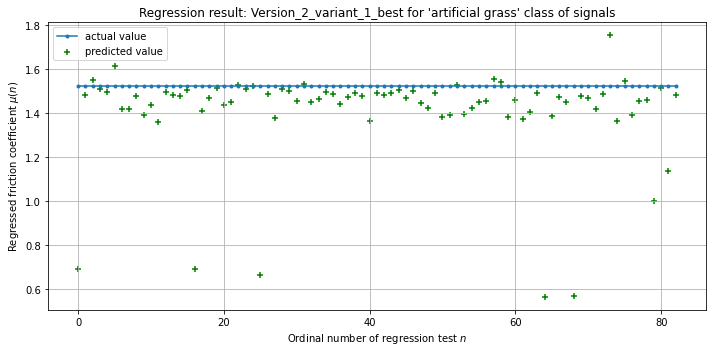

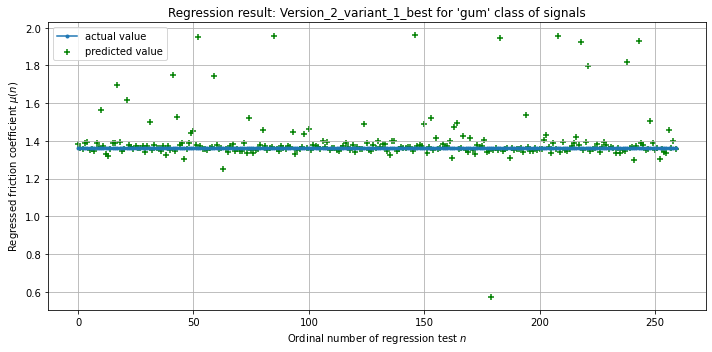

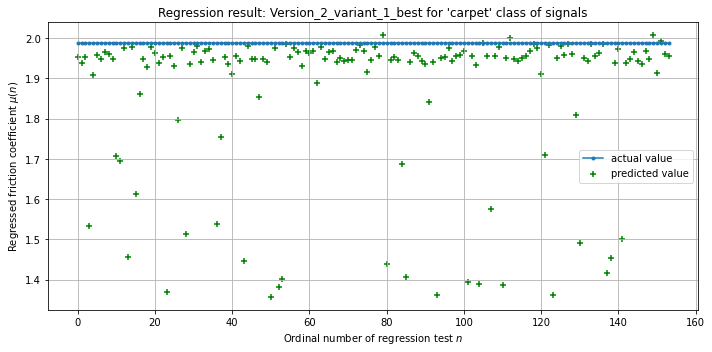

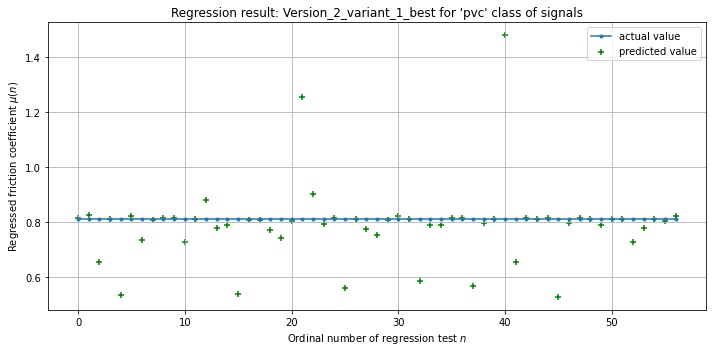

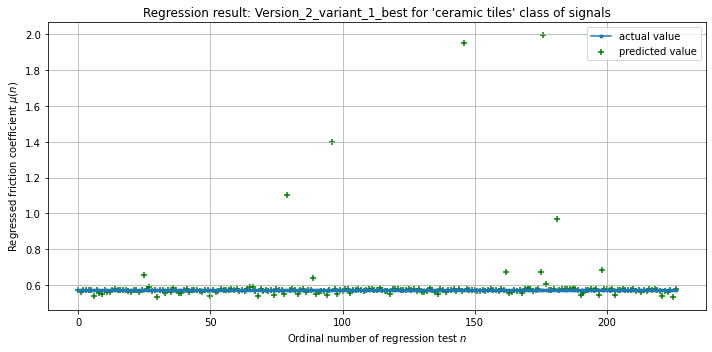

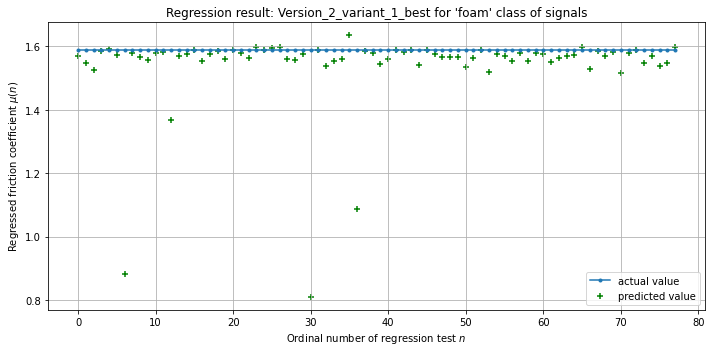

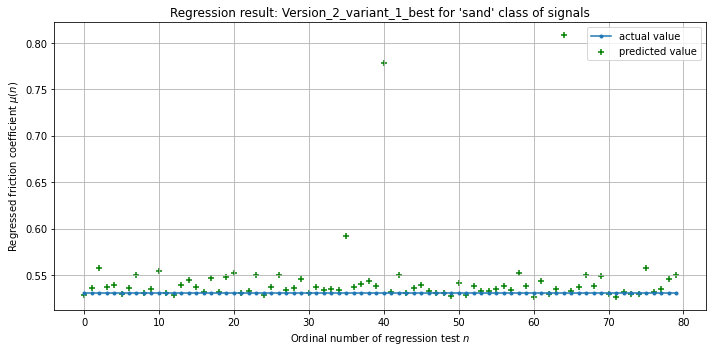

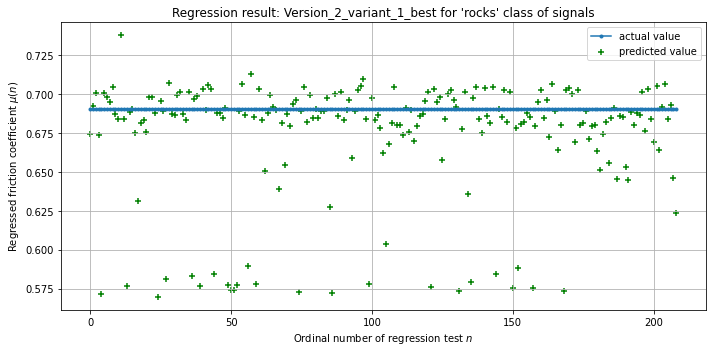

In [ ]:
# display current variant
print(current_variant)

# tests_frame is a 2D array, where i in <0,7>, j in <0, i_th_category_len> 
tests_frame = [[],[],[],[],[],[],[],[]]
actual_coefficients = [0,0,0,0,0,0,0,0]

# split tested data into arrays 
for i in range(len(y_test)):
  predicted = y_hat_put[i][0] # obtain predicted value
  actual = y_test[i] # obtain actual value
  
  tested_material = int(y_test_labels[i]) 
  tests_frame[tested_material].append(predicted)
  actual_coefficients[tested_material] = actual


# calculate average values of obtained predictions
print('--- average values ---')
average_values = [0,0,0,0,0,0,0,0]

for i in range(len(average_values)):
  average_values[i] = np.average(np.asarray(tests_frame[i]))
  print(average_values[i])


# calculate percentage differences
print("--- percentage differences ---")

percentage_differences = [0,0,0,0,0,0,0,0]

for i in range(len(percentage_differences)):
  percentage_differences[i] = 100*abs(1-average_values[i]/actual_coefficients[i])
  print(percentage_differences[i])


# calculate percentage differences
print("--- standard_deviations ---")

standard_deviations = [0,0,0,0,0,0,0,0]

for i in range(len(standard_deviations)):
  standard_deviations[i] = np.std(np.asarray(tests_frame[i]))

  print(standard_deviations[i])

print('--- accuracy metrics for the entire vector of predictions ---')
print('1. Explained Variance: ' + str(skm.explained_variance_score(y_test,y_hat_put)))
print('2. Max Error: ' + str(skm.max_error(y_test,y_hat_put)))
print('3. Mean Absolute Error: ' + str(skm.mean_absolute_error(y_test,y_hat_put)))
print('4. Root Mean Squared Error: '+str(skm.mean_squared_error(y_test,y_hat_put)))
print('5. R2 score: '+ str(skm.r2_score(y_test,y_hat_put)))

print('--- plots ---')



for i in range(len(tests_frame)):
  plt.figure(i)
  figure = plt.gcf()
  figure.set_size_inches(10, 5)
  plt.scatter([i for i in range(len(tests_frame[i]))],tests_frame[i], label = 'predicted value', c = 'green', marker = '+')
  plt.plot(len(tests_frame[i])*[actual_coefficients[i]], label = 'actual value', marker = '.')
  plt.legend(loc = 'best')
  plt.title("Regression result: " + current_variant + " for '" + ENUM_LABELS[i].lower() + "' class of signals")
  plt.grid()
  plt.xlabel("Ordinal number of regression test $n$")
  plt.ylabel("Regressed friction coefficient $\mu(n)$")

  plt.tight_layout()
  plt.savefig(model_data_dir + '/' +current_variant + '/{}_result_{}.png'.format(current_variant,i), dpi = 200)


plt.show()


# Th01: Comparison of the models in context of regressing values of unknown terrain. 

## Data preparation

Re-fit the data; drop Artificial Grass and Foam for Training and evaluation. Then, drop all the other classes of signals and check the regression quality for Artificial Grass and Foam only.

In [ ]:
# drop signals of classes: 
x_train, y_train, y_train_labels = prepare_x_y_data(dataset_loaded, 'train_ds', True, [0,5])
x_val, y_val, y_val_labels = prepare_x_y_data(dataset_loaded, 'val_ds', True, [0,5])
x_test, y_test, y_test_labels = prepare_x_y_data(dataset_loaded, 'test_ds', True, [1,2,3,4,6,7])

# augment the train dataset with all the signals not dropped for test
x_train_aug, y_train_aug, y_train_labels_aug = prepare_x_y_data(dataset_loaded, 'test_ds', True, [0,5])

# ...
x_train = x_train + x_train_aug
y_train = y_train + y_train_aug
y_train_labels = y_train_labels + y_train_labels_aug

# augment the test dataset with Art. Grass & Foam classes of signals
x_test_aug_1, y_test_aug_1, y_test_labels_aug_1 = prepare_x_y_data(dataset_loaded, 'train_ds', True, [1,2,3,4,6,7]) # only 0, 5 labels remain
x_test_aug_2, y_test_aug_2, y_test_labels_aug_2  = prepare_x_y_data(dataset_loaded, 'val_ds', True, [1,2,3,4,6,7])

# ...
x_test = x_test + x_test_aug_1 + x_test_aug_2
y_test = y_test + y_test_aug_1 + y_test_aug_2
y_test_labels = y_test_labels + y_test_labels_aug_1 + y_test_labels_aug_2

In train_ds -> x array length = 2959 shape elements in x = (160, 6)
In train_ds -> y array length = 2959 y[0] = 0.5753798660343042
In train_ds -> y array length = 2959 y_labels[0] = 4
In val_ds -> x array length = 986 shape elements in x = (160, 6)
In val_ds -> y array length = 986 y[0] = 0.6905819975288582
In val_ds -> y array length = 986 y_labels[0] = 7
In test_ds -> x array length = 161 shape elements in x = (160, 6)
In test_ds -> y array length = 161 y[0] = 1.5229850247598293
In test_ds -> y array length = 161 y_labels[0] = 0
In test_ds -> x array length = 987 shape elements in x = (160, 6)
In test_ds -> y array length = 987 y[0] = 0.5753798660343042
In test_ds -> y array length = 987 y_labels[0] = 4
In train_ds -> x array length = 484 shape elements in x = (160, 6)
In train_ds -> y array length = 484 y[0] = 1.5229850247598293
In train_ds -> y array length = 484 y_labels[0] = 0
In val_ds -> x array length = 162 shape elements in x = (160, 6)
In val_ds -> y array length = 162 y[0] 

Re-compile the models

In [ ]:
from tensorflow_addons.optimizers import AdamW
lr = 0.001
wd = 2e-4


regressor.compile(optimizer=AdamW(weight_decay=wd,learning_rate=lr),loss='MAE')
regressor_putnn.compile(optimizer=AdamW(weight_decay=wd,learning_rate=lr),loss='MAE')

## Robust Regressor

Re-train Robust Regressor

In [ ]:
current_variant = 'Version_1_unknown_terrain'



if load_weights[2] == True:
  regressor.load_weights(model_data_dir + '/' +current_variant)
  
else:
  checkpoint = ModelCheckpoint(filepath=model_data_dir + '/' +current_variant,
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
  
  
  callbacks  = [checkpoint]

  regressor.fit(x = np.asarray(x_train), y = np.asarray(y_train), validation_data=(np.asarray(x_val),np.asarray(y_val)), epochs= 100,callbacks= callbacks, batch_size=16)


Validate 

In [ ]:
metrics = regressor.evaluate(x = np.asarray(x_val), y = np.asarray(y_val))
print('MAE on validation data: ' + str(metrics))

31/31 [==============================] - 1s 24ms/step - loss: 0.0967
MAE on validation data: 0.09669796377420425


Obtain coefficient estimates:

In [ ]:
y_hat_1 = regressor.predict(x = np.asarray(x_test), batch_size = 1)

Display model evaluation metrics:

Version_1_unknown_terrain
--- average values ---
1.1501665
nan
nan
nan
nan
1.3194811
nan
nan
--- percentage differences ---
24.47946021550522
nan
nan
nan
nan
16.896050649301408
nan
nan
--- standard_deviations ---
0.45488295
nan
nan
nan
nan
0.32736295
nan
nan
--- accuracy metrics for the entire vector of predictions ---
1. Explained Variance: -153.13775925321144
2. Max Error: 0.9622400239205959
3. Mean Absolute Error: 0.4195871302553365
4. Root Mean Squared Error: 0.26531274716910686
5. R2 score: -252.31068583289345
--- plots ---


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


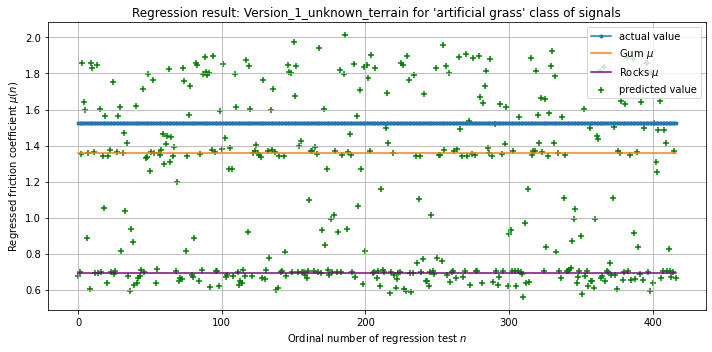

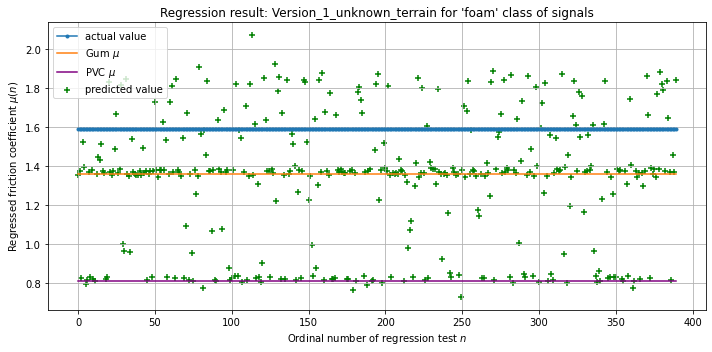

In [ ]:
# display current variant
print(current_variant)

# tests_frame is a 2D array, where i in <0,7>, j in <0, i_th_category_len> 
tests_frame = [[],[],[],[],[],[],[],[]]
actual_coefficients = [0,0,0,0,0,0,0,0]

# split tested data into arrays 
for i in range(len(y_test)):
  predicted = y_hat_1[i][0] # obtain predicted value
  actual = y_test[i] # obtain actual value
  
  tested_material = int(y_test_labels[i]) 
  tests_frame[tested_material].append(predicted)
  actual_coefficients[tested_material] = actual


# calculate average values of obtained predictions
print('--- average values ---')
average_values = [0,0,0,0,0,0,0,0]

for i in range(len(average_values)):
  average_values[i] = np.average(np.asarray(tests_frame[i]))
  print(average_values[i])


# calculate percentage differences
print("--- percentage differences ---")

percentage_differences = [0,0,0,0,0,0,0,0]

for i in range(len(percentage_differences)):
  percentage_differences[i] = 100*abs(1-average_values[i]/actual_coefficients[i])
  print(percentage_differences[i])


# calculate percentage differences
print("--- standard_deviations ---")

standard_deviations = [0,0,0,0,0,0,0,0]

for i in range(len(standard_deviations)):
  standard_deviations[i] = np.std(np.asarray(tests_frame[i]))
  
  print(standard_deviations[i])

print('--- accuracy metrics for the entire vector of predictions ---')
print('1. Explained Variance: ' + str(skm.explained_variance_score(y_test,y_hat_1)))
print('2. Max Error: ' + str(skm.max_error(y_test,y_hat_1)))
print('3. Mean Absolute Error: ' + str(skm.mean_absolute_error(y_test,y_hat_1)))
print('4. Root Mean Squared Error: '+str(skm.mean_squared_error(y_test,y_hat_1)))
print('5. R2 score: '+ str(skm.r2_score(y_test,y_hat_1)))

print('--- plots ---')

for i in range(len(tests_frame)):
  if len(tests_frame[i]) >0:
    plt.figure(i)
    figure = plt.gcf()
    figure.set_size_inches(10, 5)

    plt.plot(len(tests_frame[i])*[actual_coefficients[i]], label = 'actual value', marker = '.')
    if i == 0: 
      plt.plot(len(tests_frame[i])*[1.36], label = 'Gum $\mu$') # gum level
      plt.plot(len(tests_frame[i])*[0.69], label = 'Rocks $\mu$', c = 'purple') # rocks level
    
    if i == 5:
      plt.plot(len(tests_frame[i])*[1.36], label = 'Gum $\mu$') # gum level
      plt.plot(len(tests_frame[i])*[0.81], label = 'PVC $\mu$', c = 'purple') # rocks level
    

    plt.scatter([i for i in range(len(tests_frame[i]))],tests_frame[i], label = 'predicted value', c = 'green', marker ='+')

    
    
    plt.legend(loc = 'best')
    plt.title("Regression result: " + current_variant + " for '" + ENUM_LABELS[i].lower() + "' class of signals")
    plt.grid()
    plt.xlabel("Ordinal number of regression test $n$")
    plt.ylabel("Regressed friction coefficient $\mu(n)$")



    plt.tight_layout()
    plt.savefig(model_data_dir + '/' +current_variant + '/{}_result_{}.png'.format(current_variant,i), dpi = 200)

plt.show()


## PUT Regressor 


Re-train PUT Regressor

In [ ]:
current_variant = 'Version_2_unknown_terrain'

if load_weights[3] == True:
  regressor_putnn.load_weights(model_data_dir + '/' +current_variant)
else :
  checkpoint = ModelCheckpoint(filepath=model_data_dir + '/' +current_variant,
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
  
  #early_stopping = EarlyStopping(patience = 10, verbose = 1, monitor = 'loss')
  
  callbacks  = [checkpoint]

  regressor_putnn.fit(x = np.asarray(x_train), y = np.asarray(y_train), epochs= 100,callbacks= callbacks, validation_data=(np.asarray(x_val), np.asarray(y_val)), batch_size= 16)

Validate 

In [ ]:
metrics = regressor_putnn.evaluate(x = np.asarray(x_val), y = np.asarray(y_val))
print('MAE on validation data: ' + str(metrics))

31/31 [==============================] - 3s 32ms/step - loss: 0.0919
MAE on validation data: 0.09191616624593735


Evaluate results; PUT Regressor

In [ ]:
# regress xD
y_hat_put = regressor_putnn.predict(x = np.asarray(x_test), batch_size = 16)

Version_2_unknown_terrain
--- average values ---
1.1369734
nan
nan
nan
nan
1.2758629
nan
nan
--- percentage differences ---
25.345728122193577
nan
nan
nan
nan
19.64322510495783
nan
nan
--- standard_deviations ---
0.54216135
nan
nan
nan
nan
0.35005227
nan
nan
--- accuracy metrics for the entire vector of predictions ---
1. Explained Variance: -201.86532932029473
2. Max Error: 0.970806939909518
3. Mean Absolute Error: 0.5013857139899703
4. Root Mean Squared Error: 0.33510910177158615
5. R2 score: -318.9496341745679
--- plots ---


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


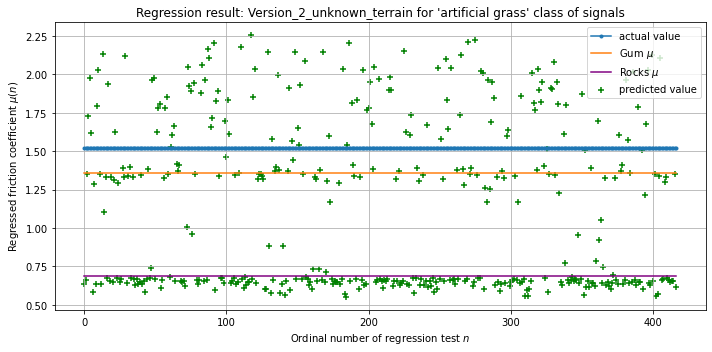

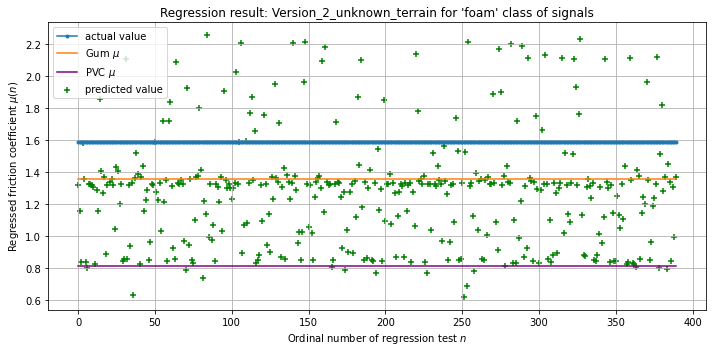

In [ ]:
# display current variant
print(current_variant)

# tests_frame is a 2D array, where i in <0,7>, j in <0, i_th_category_len> 
tests_frame = [[],[],[],[],[],[],[],[]]
actual_coefficients = [0,0,0,0,0,0,0,0]

# split tested data into arrays 
for i in range(len(y_test)):
  predicted = y_hat_put[i][0] # obtain predicted value
  actual = y_test[i] # obtain actual value
  
  tested_material = int(y_test_labels[i]) 
  tests_frame[tested_material].append(predicted)
  actual_coefficients[tested_material] = actual


# calculate average values of obtained predictions
print('--- average values ---')
average_values = [0,0,0,0,0,0,0,0]

for i in range(len(average_values)):
  average_values[i] = np.average(np.asarray(tests_frame[i]))
  print(average_values[i])


# calculate percentage differences
print("--- percentage differences ---")

percentage_differences = [0,0,0,0,0,0,0,0]

for i in range(len(percentage_differences)):
  percentage_differences[i] = 100*abs(1-average_values[i]/actual_coefficients[i])
  print(percentage_differences[i])


# calculate percentage differences
print("--- standard_deviations ---")

standard_deviations = [0,0,0,0,0,0,0,0]

for i in range(len(standard_deviations)):
  standard_deviations[i] = np.std(np.asarray(tests_frame[i]))

  print(standard_deviations[i])

print('--- accuracy metrics for the entire vector of predictions ---')
print('1. Explained Variance: ' + str(skm.explained_variance_score(y_test,y_hat_put)))
print('2. Max Error: ' + str(skm.max_error(y_test,y_hat_put)))
print('3. Mean Absolute Error: ' + str(skm.mean_absolute_error(y_test,y_hat_put)))
print('4. Root Mean Squared Error: '+str(skm.mean_squared_error(y_test,y_hat_put)))
print('5. R2 score: '+ str(skm.r2_score(y_test,y_hat_put)))

print('--- plots ---')



for i in range(len(tests_frame)):
  if len(tests_frame[i]) >0:
    plt.figure(i)
    figure = plt.gcf()
    figure.set_size_inches(10, 5)
    
    plt.plot(len(tests_frame[i])*[actual_coefficients[i]], label = 'actual value', marker = '.')

    if i == 0: 
      plt.plot(len(tests_frame[i])*[1.36], label = 'Gum $\mu$') # gum level
      plt.plot(len(tests_frame[i])*[0.69], label = 'Rocks $\mu$', c = 'purple') # rocks level
    
    if i == 5:
      plt.plot(len(tests_frame[i])*[1.36], label = 'Gum $\mu$') # gum level
      plt.plot(len(tests_frame[i])*[0.81], label = 'PVC $\mu$', c = 'purple') # rocks level
    
    plt.scatter([i for i in range(len(tests_frame[i]))],tests_frame[i], label = 'predicted value', c = 'green', marker = '+')

    plt.legend(loc = 'best')
    plt.title("Regression result: " + current_variant + " for '" + ENUM_LABELS[i].lower() + "' class of signals")
    plt.grid()
    plt.xlabel("Ordinal number of regression test $n$")
    plt.ylabel("Regressed friction coefficient $\mu(n)$")

    plt.tight_layout()
    plt.savefig(model_data_dir + '/' +current_variant + '/{}_result_{}.png'.format(current_variant,i), dpi = 200)


plt.show()
